## 前處理

In [28]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np
torch.manual_seed(0)

In [29]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

In [30]:
IMAGE_SIZE = 28 # Original size: 28

composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)) ,transforms.ToTensor(),])

In [31]:
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=composed)
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=composed)

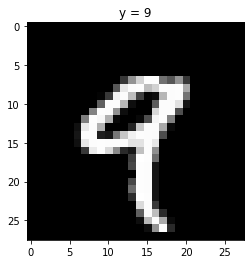

In [32]:
show_data(train_dataset[4])

## CNN(final layer no softmax)

In [33]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('GPU is avalible')
  print('-Training on GPU-')
else:
  device = torch.device('cpu')
  print('GPU is not avalible')
  print('Train on CPU')

GPU is avalible
-Training on GPU-


In [34]:
class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 7 * 7, 10)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [35]:
model = CNN(out_1=16, out_2=32)
model.to(device)

CNN(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
)

In [36]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=4096)

In [37]:
def train_model(model,train_loader,validation_loader,optimizer,n_epochs=4):
    
  N_test=len(validation_dataset)
  N_train=len(train_dataset)

  train_acc=[] #training_accuracy
  cv_acc=[]   #validatiob_accuracy
  #trainning_loss=[]   #training_loss
  train_cost=[]   #training_cost (sum of training_loss)
  cv_cost=[]     #validation_cost

  for epoch in range(n_epochs):
    #training
    cost = 0
    correct = 0
    model.train()
    for x, y in train_loader:
      x, y = x.to(device), y.to(device)
      optimizer.zero_grad()
      z = model(x)
      _, yhat = torch.max(z.data, 1)
      correct += (yhat == y).sum().item()
      loss = criterion(z, y)
      loss.backward()
      optimizer.step()
      #trainning_loss.append(loss.data)
      cost += loss.item()
    cost = cost / N_train   
    train_cost.append(cost)
    accuracy = correct / N_train
    train_acc.append(accuracy)

    #validation
    correct=0
    cost=0
    model.eval()
    with torch.no_grad(): 
      for x_test, y_test in validation_loader:
        x_test, y_test= x_test.to(device), y_test.to(device)
        z = model(x_test)
        _, yhat = torch.max(z.data, 1)
        correct += (yhat == y_test).sum().item()
        loss = criterion(z, y_test)
        cost += loss.item()
      cost = cost / N_test
      cv_cost.append(cost)
      accuracy = correct / N_test
      cv_acc.append(accuracy)
     
  return   train_acc, cv_acc, train_cost, cv_cost#, trainning_loss

In [38]:
%%time
train_acc, cv_acc, train_cost, cv_cost = train_model(model=model,n_epochs=4,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)

Wall time: 42.9 s


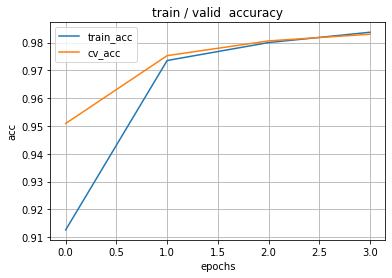

In [39]:
plt.plot(train_acc,label='train_acc')
plt.plot(cv_acc ,label='cv_acc')
plt.title('train / valid  accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend()
plt.grid()
plt.show()

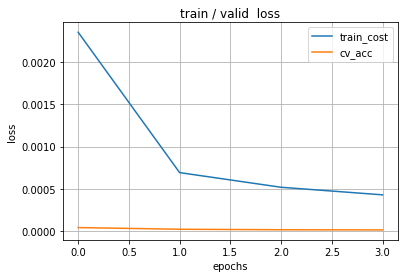

In [40]:
plt.plot(train_cost,label='train_cost')
plt.plot(cv_cost,label='cv_acc')
plt.title('train / valid  loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

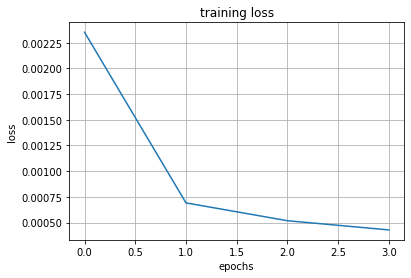

In [41]:
plt.plot(train_cost,label='train_cost')
plt.grid()
plt.title('training loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

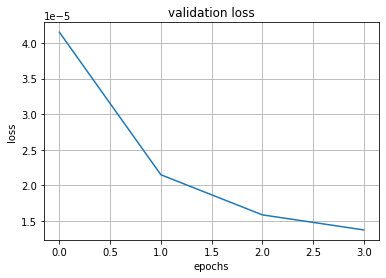

In [42]:
plt.plot(cv_cost,label='cv_acc')
plt.grid()
plt.title('validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [43]:
print('train_acc:',train_acc)
print('cv_acc:',cv_acc)
print('train_cost:',train_cost)
print('cv_cost:',cv_cost)

train_acc: [0.9126166666666666, 0.97355, 0.98, 0.9837166666666667]
cv_acc: [0.9509, 0.9753, 0.9806, 0.983]
train_cost: [0.0023516049129733195, 0.0006914752572348031, 0.0005180871817904214, 0.0004286027627104583]
cv_cost: [4.15043368935585e-05, 2.1481846645474435e-05, 1.584835648536682e-05, 1.3731084018945694e-05]


## CNN(final layer with softmax)

In [44]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('GPU is avalible')
  print('-Training on GPU-')
else:
  device = torch.device('cpu')
  print('GPU is not avalible')
  print('Train on CPU')

GPU is avalible
-Training on GPU-


In [45]:
class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 7 * 7, 10)
        self.softmax = nn.Softmax(dim=1)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        #print('before flatten:',x.size())
        x = x.view(x.size(0), -1)
        #print('after flatten:',x.size())
        x = self.fc1(x)
        #print('after full connect:',x.size())
        x = self.softmax(x)
        #print('after softmax:',x.size())
        return x

In [46]:
model = CNN(out_1=16, out_2=32)
model.to(device)

CNN(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [47]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=4096)

In [48]:
def train_model(model,train_loader,validation_loader,optimizer,n_epochs=4):
    
  N_test=len(validation_dataset)
  N_train=len(train_dataset)

  train_acc=[] #training_accuracy
  cv_acc=[]   #validatiob_accuracy
  #trainning_loss=[]   #training_loss
  train_cost=[]   #training_cost (sum of training_loss)
  cv_cost=[]     #validation_cost

  for epoch in range(n_epochs):
    #training
    cost = 0
    correct = 0
    model.train()
    for x, y in train_loader:
      x, y = x.to(device), y.to(device)
      optimizer.zero_grad()
      z = model(x)
      _, yhat = torch.max(z.data, 1)
      correct += (yhat == y).sum().item()
      loss = criterion(z, y)
      loss.backward()
      optimizer.step()
      #trainning_loss.append(loss.data)
      cost += loss.item()
    cost = cost / N_train   
    train_cost.append(cost)
    accuracy = correct / N_train
    train_acc.append(accuracy)

    #validation
    correct=0
    cost=0
    model.eval()
    with torch.no_grad(): 
      for x_test, y_test in validation_loader:
        x_test, y_test= x_test.to(device), y_test.to(device)
        z = model(x_test)
        _, yhat = torch.max(z.data, 1)
        correct += (yhat == y_test).sum().item()
        loss = criterion(z, y_test)
        cost += loss.item()
      cost = cost / N_test
      cv_cost.append(cost)
      accuracy = correct / N_test
      cv_acc.append(accuracy)
     
  return   train_acc, cv_acc, train_cost, cv_cost#, trainning_loss

In [49]:
%%time
train_acc, cv_acc, train_cost, cv_cost = train_model(model=model,n_epochs=4,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)

Wall time: 42.6 s


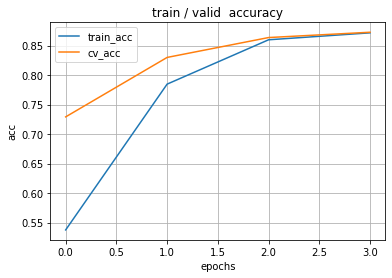

In [50]:
plt.plot(train_acc,label='train_acc')
plt.plot(cv_acc ,label='cv_acc')
plt.title('train / valid  accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend()
plt.grid()
plt.show()

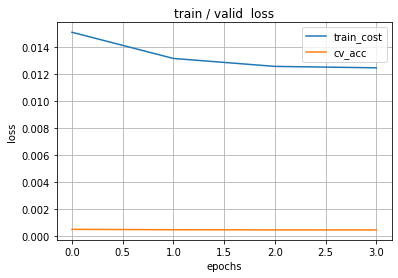

In [51]:
plt.plot(train_cost,label='train_cost')
plt.plot(cv_cost,label='cv_acc')
plt.title('train / valid  loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

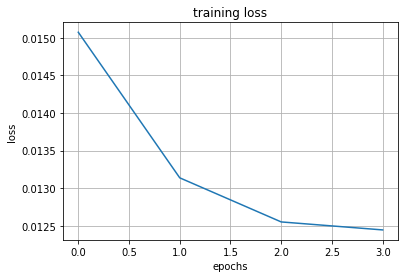

In [52]:
plt.plot(train_cost,label='train_cost')
plt.grid()
plt.title('training loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

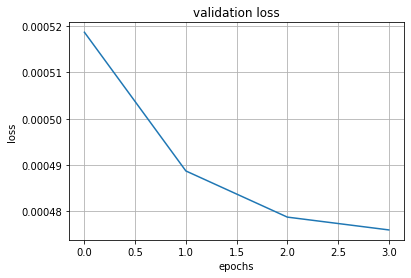

In [53]:
plt.plot(cv_cost,label='cv_acc')
plt.grid()
plt.title('validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [54]:
print('train_acc:',train_acc)
print('cv_acc:',cv_acc)
print('train_cost:',train_cost)
print('cv_cost:',cv_cost)

train_acc: [0.5374333333333333, 0.7846333333333333, 0.8598, 0.8716]
cv_acc: [0.7291, 0.8299, 0.8636, 0.8726]
train_cost: [0.015072649262348812, 0.013137494045495987, 0.012551408676306407, 0.012445194615920386]
cv_cost: [0.0005186910390853882, 0.000488691771030426, 0.00047870874404907224, 0.0004759382963180542]
